In [3]:
import paddle
import numpy as np
import matplotlib.pyplot as plt
import os
print(paddle.__version__)

2.4.0


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [4]:
# 读取数据集
import pandas as pd
train = pd.read_table('./data/data206079/Train.txt', sep='\t',header=None)  # 有标签的训练数据文件
test = pd.read_table('./data/data206079/Test.txt', sep='\t',header=None)    # 要进行预测的测试数据文件
import os

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

# 设置显示中文
matplotlib.rcParams['font.sans-serif'] = ['FZSongYi-Z13S'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# 设置字体大小
matplotlib.rcParams['font.size'] = 16

In [6]:
# 添加列名
train.columns = ['id',"label","text_a"]
test.columns = [['text_a']]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83599 entries, 0 to 83598
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   (text_a,)  83599 non-null  object
dtypes: object(1)
memory usage: 653.2+ KB


In [ ]:
# 训练数据类别标签分布统计
train['label'].value_counts()

科技    146637
股票    138959
体育    118444
娱乐     83369
时政     56778
社会     45765
教育     37743
财经     33389
家居     29328
游戏     21936
房产     18045
时尚     12032
彩票      6830
星座      3221
Name: label, dtype: int64

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


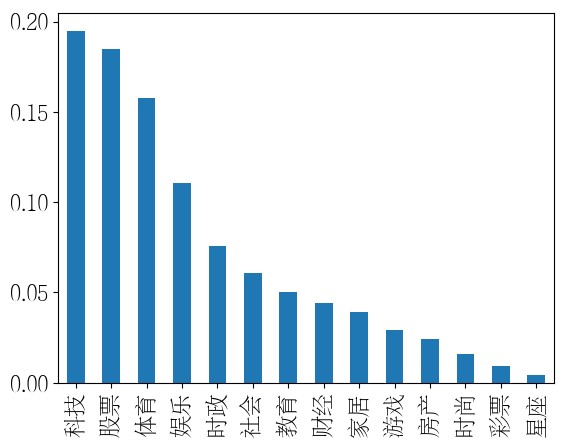

In [ ]:
# 可视化类别标签分布情况
train['label'].value_counts(normalize=True).plot(kind='bar');

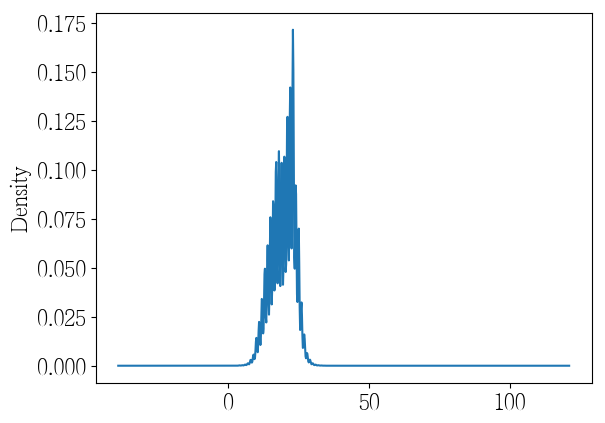

In [ ]:
# 可视化训练集文本长度分布
train['text_a'].astype(str).map(len).plot(kind='kde');

In [ ]:
from sklearn.utils import shuffle

new_train = pd.DataFrame()  # 定义新训练集
new_valid = pd.DataFrame()  # 定义新验证集

tags = list(train.label.unique())  # 总类别

# 根据类别进行抽样划分
for tag in tags:
    data = train[(train['label'] == tag)]
    # 抽样取0.1作为验证集
    valid_sample = data.sample(int(0.1 * len(data)))
    valid_index = valid_sample.index
    # 将剩余0.9的数据作为训练集
    all_index = data.index
    residue_index = all_index.difference(valid_index)
    residue = data.loc[residue_index]
    # 对取的数据进行保存
    new_valid = pd.concat([new_valid, valid_sample], ignore_index=True)
    new_train = pd.concat([new_train, residue], ignore_index=True)

# 对划分后的数据进行随机打乱
new_train = shuffle(new_train)
new_valid = shuffle(new_valid)

# 保存训练和验证集文件
new_train.to_csv('train.csv', sep='\t', index=False)   # 训练集
new_valid.to_csv('valid.csv', sep='\t', index=False)   # 验证集


In [7]:
import paddlehub as hub
# 设置固定随机种子便于结果的复现
seed = 1024
import random
import numpy as np
import paddle
random.seed(seed)
np.random.seed(seed)
paddle.seed(seed)

In [8]:
# 设置要求进行文本分类的14个类别
label_list=list(train.label.unique())
print(label_list)

label_map = { 
    idx: label_text for idx, label_text in enumerate(label_list)
}
print(label_map)

['财经', '彩票', '房产', '股票', '家居', '教育', '科技', '社会', '时尚', '时政', '体育', '星座', '游戏', '娱乐']
{0: '财经', 1: '彩票', 2: '房产', 3: '股票', 4: '家居', 5: '教育', 6: '科技', 7: '社会', 8: '时尚', 9: '时政', 10: '体育', 11: '星座', 12: '游戏', 13: '娱乐'}


In [ ]:
!hub install roberta-wwm-ext-large

[2023-04-05 16:36:58,203] [    INFO] - Module roberta-wwm-ext-large already installed in /home/aistudio/.paddlehub/modules/roberta_wwm_ext_large


In [10]:
# 选择在中文领域效果较优的roberta-wwm-ext-large预训练模型并设置微调任务为14分类任务
model = hub.Module(name="roberta_wwm_ext_large", task='seq-cls', num_classes=14, label_map=label_map)

[2023-04-05 16:50:33,023] [    INFO] - We are using <class 'paddlenlp.transformers.roberta.modeling.RobertaForSequenceClassification'> to load 'hfl/roberta-wwm-ext-large'.
[2023-04-05 16:50:33,025] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/roberta_chn_large.pdparams


In [11]:
import os, io, csv
from paddlehub.datasets.base_nlp_dataset import InputExample, TextClassificationDataset
# 数据集存放位置路径
DATA_DIR="/home/aistudio"

In [12]:
# 对训练数据（训练集和验证集）进行格式处理，处理为模型可接受的格式
class News(TextClassificationDataset):
    def __init__(self, tokenizer, mode='train', max_seq_len=128):
        if mode == 'train':
            data_file = 'train.csv'
        elif mode == 'dev':
            data_file = 'valid.csv'
        super(News, self).__init__(
            base_path=DATA_DIR,
            data_file=data_file,
            tokenizer = tokenizer,
            max_seq_len=max_seq_len,
            mode=mode,
            is_file_with_header=True,
            label_list=label_list
            )

    # 解析文本文件里的样本
    def _read_file(self, input_file, is_file_with_header: bool = False):
        if not os.path.exists(input_file):
            raise RuntimeError("The file {} is not found.".format(input_file))
        else:
            with io.open(input_file, "r", encoding="UTF-8") as f:
                reader = csv.reader(f, delimiter="\t")  # ‘\t’分隔数据
                examples = []
                seq_id = 0
                header = next(reader) if is_file_with_header else None
                for line in reader:
                    example = InputExample(guid=seq_id, text_a=line[0], label=line[1])
                    seq_id += 1
                    examples.append(example)
                return examples

# 最大序列长度max_seq_len是可调整的重要参数-->待调整
train_dataset = News( model.get_tokenizer(), mode='train', max_seq_len=48 ) # '''
dev_dataset = News( model.get_tokenizer(), mode='dev', max_seq_len=48)

# 处理完后查看处理后的数据前3条
for e in train_dataset.examples[:3]:
    print(e)
for e in dev_dataset.examples[:3]:
    print(e)


[2023-04-05 16:50:44,748] [    INFO] - We are using <class 'paddlenlp.transformers.roberta.tokenizer.RobertaChineseTokenizer'> to load 'hfl/roberta-wwm-ext-large'.
[2023-04-05 16:50:44,750] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/vocab.txt
[2023-04-05 16:50:44,764] [    INFO] - tokenizer config file saved in /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/tokenizer_config.json
[2023-04-05 16:50:44,766] [    INFO] - Special tokens file saved in /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/special_tokens_map.json
[2023-04-05 16:52:50,285] [    INFO] - We are using <class 'paddlenlp.transformers.roberta.tokenizer.RobertaChineseTokenizer'> to load 'hfl/roberta-wwm-ext-large'.
[2023-04-05 16:52:50,289] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/vocab.txt
[2023-04-05 16:52:50,304] [    INFO] - tokenizer config file saved in /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-l

text=10	label=体育
text=8	label=时尚
text=7	label=社会
text=4	label=家居
text=6	label=科技
text=0	label=财经


In [13]:
import paddle
# 优化器的选择
optimizer = paddle.optimizer.AdamW(learning_rate=0.00001, weight_decay=0.00001, parameters=model.parameters())
# 训练运行配置
trainer = hub.Trainer(model, optimizer, checkpoint_dir='./ckpt', use_gpu=True, use_vdl=True)

[2023-04-05 16:53:26,498] [ WARNING] - PaddleHub model checkpoint not found, start from scratch...


In [18]:
# 模型训练：配置训练参数，指定验证集，启动训练
trainer.train(train_dataset, epochs=3, batch_size=256, eval_dataset=dev_dataset, save_interval=1)

In [14]:
# 对测试集进行预测：
import numpy as np
# 将输入数据进行格式处理，处理为list格式
data_array = np.array(test)
data_list =data_array.tolist()

# 加载训练好的模型
model = hub.Module(
    name="roberta-wwm-ext-large", 
    task='seq-cls', 
    load_checkpoint='./ckpt/best_model/model.pdparams',  # 加载最优一轮的模型参数
    num_classes=14, 
    label_map=label_map)

# 对测试集数据进行预测:
predictions = model.predict(data_list, max_seq_len=48, batch_size=32, use_gpu=True)

[2023-04-05 16:53:30,742] [    INFO] - We are using <class 'paddlenlp.transformers.roberta.modeling.RobertaForSequenceClassification'> to load 'hfl/roberta-wwm-ext-large'.
[2023-04-05 16:53:30,744] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/roberta_chn_large.pdparams
[2023-04-05 16:53:34,015] [    INFO] - We are using <class 'paddlenlp.transformers.roberta.tokenizer.RobertaChineseTokenizer'> to load 'hfl/roberta-wwm-ext-large'.
[2023-04-05 16:53:34,021] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/vocab.txt
[2023-04-05 16:53:34,035] [    INFO] - tokenizer config file saved in /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/tokenizer_config.json
[2023-04-05 16:53:34,039] [    INFO] - Special tokens file saved in /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/special_tokens_map.json


In [15]:
# 预测结果存储为要求格式 txt文件
def write_results(labels, file_path):
    with open(file_path, "w", encoding="utf8") as f:
        f.writelines("\n".join(labels))

write_results(predictions, "./result.txt")